# Setup

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


'ghp_z(HayhkIaeF11Invg1KGWKjWYvfi150358zH'

ghp_z(HayhkIaeF11Invg1KGWKjWYvfi150358zH

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Emotion vgg cnn + training monitor callback

In [4]:
# UNDERFITTING - occurs when the model cannot obtain a low enough loss on the training set => model fails to learn the underlying patters in the training data

# OVERFITTING - where network models the training data too well + fails to generalize to the validation data

# goal is to reduce training loss + ensure gap between training & testing loss is small

# control fitting by adjusting CAPACITY of the network
    # increase it by adding layers + neurons => reach "optimal" of network
    # decrease it by removing layers & neurons + using regularization methods

# training & validation loss/accuracy start to diverge from each other => noticeable gap => GOAL is to limit the gap => preserve the generalizability of the model
    # if gap isnt limited => "OVERFITTING ZONE" => training loss will either stagnate/continue to drop + validation loss stagnates & increases (heavy indicator of overfitting)

# combat overfitting? reduce complexity (less layers & neurons) + applying regularization methods (weight decay, dropout, data augmentation)

# import the necessary packages
from keras.callbacks import BaseLogger # used to create a class that logs the losses & acccuracy to the disk
import matplotlib.pyplot as plt
import numpy as np
import json
import os

class TrainingMonitor(BaseLogger):

    def __init__(self, figPath, jsonPath=None, startAt=0):
    
        # figPath = path to output plot thay can be used to visualize loss & accuracy over time
        # jsonPath = path used to serialize the loss & accuracy values as a JSON file (useful to see the training history to create custome plots)
        # startAt = staring epoch that training is resumed at using ctrl + c training
        
        
        # store the output path for the figure, the path to the JSON serialized file, and the starting epoch
        super(TrainingMonitor, self).__init__()
        self.figPath = figPath
        self.jsonPath = jsonPath
        self.startAt = startAt
        
    def on_train_begin(self, logs={}):
    
        # initialize the history dictionary ("history" of losses)
        self.H = {}
     
        # if the JSON history path exists, load the training history
        if self.jsonPath is not None:
            if os.path.exists(self.jsonPath):
                self.H = json.loads(open(self.jsonPath).read())
               
                # check to see if a starting epoch was supplied
                if self.startAt > 0:
                    # loop over the entries in the history log and trim any entries that are past the starting epoch
                    for k in self.H.keys():
                         self.H[k] = self.H[k][:self.startAt]

    def on_epoch_end(self, epoch, logs={}): # is called when a training epoch completes
        # epoch = epoch #
        # logs = contains the training & validation loss + accuracy for current epoch
    
        # loop over the logs and update the loss, accuracy, etc. for the entire training process
        for (k, v) in logs.items():
            l = self.H.get(k, [])
            l.append(v)
            self.H[k] = l
            
            #after code is executed H has 4 keys (train_loss, train_accuracy, val_loss, val_accuracy) => a list is kept for each of the values => each list is updated after every epoch => plot an updated loss & accuracy curve as soon as the epoch completes
            
        # check to see if the training history should be serialized to file
        if self.jsonPath is not None:
            f = open(self.jsonPath, "w")
            f.write(json.dumps(self.H))
            f.close()

        # ensure at least two epochs have passed before plotting (epoch starts at zero)
        if len(self.H["loss"]) > 1:
            # plot the training loss and accuracy
            N = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            plt.plot(N, self.H["loss"], label="train_loss")
            plt.plot(N, self.H["val_loss"], label="val_loss")
            plt.plot(N, self.H["accuracy"], label="train_accuracy")
            plt.plot(N, self.H["val_accuracy"], label="val_accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(len(self.H["loss"])))
            plt.xlabel("Epoch Number")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            
            # save the figure
            plt.savefig(self.figPath)
            plt.close()

In [5]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ELU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

# Initial cu matrice de confuzie si best model save

Rezultatele se vor gasi in outputs/output1

Modelul cel mai bun se salveaza in folder-ul checkpoint.



---



ANTRENARE

Aici se antreneaza setul de date de train si de validation.

In [6]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output1'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 318s 10s/step - loss: 1.9945 - accuracy: 0.3531 - val_loss: 4.6547 - val_accuracy: 0.1875
Epoch 2/50
 4/33 [==>...........................] - ETA: 21s - loss: 1.6300 - accuracy: 0.4102

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.4075 - accuracy: 0.4740 - val_loss: 2.7606 - val_accuracy: 0.2871
Epoch 3/50
11/33 [=========>....................] - ETA: 15s - loss: 1.2375 - accuracy: 0.5207

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.2206 - accuracy: 0.5372 - val_loss: 2.0951 - val_accuracy: 0.3281
Epoch 4/50
29/33 [=========================>....] - ETA: 2s - loss: 1.0370 - accuracy: 0.6073

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 903ms/step - loss: 1.0439 - accuracy: 0.6032 - val_loss: 1.6984 - val_accuracy: 0.3535
Epoch 5/50
18/33 [===============>..............] - ETA: 11s - loss: 0.9561 - accuracy: 0.6347

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 0.9684 - accuracy: 0.6328 - val_loss: 1.6858 - val_accuracy: 0.3984
Epoch 6/50
27/33 [=======================>......] - ETA: 4s - loss: 0.8978 - accuracy: 0.6555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 923ms/step - loss: 0.8885 - accuracy: 0.6583 - val_loss: 0.9846 - val_accuracy: 0.6504
Epoch 7/50
24/33 [====================>.........] - ETA: 6s - loss: 0.8318 - accuracy: 0.6831

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.8387 - accuracy: 0.6821 - val_loss: 1.2015 - val_accuracy: 0.5430
Epoch 8/50
 1/33 [..............................] - ETA: 26s - loss: 0.8143 - accuracy: 0.6953

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 902ms/step - loss: 0.7386 - accuracy: 0.7171 - val_loss: 0.8965 - val_accuracy: 0.6602
Epoch 9/50
33/33 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.7317

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint/assets
33/33 [==============================] - 30s 903ms/step - loss: 0.6976 - accuracy: 0.7317 - val_loss: 0.8105 - val_accuracy: 0.6836
Epoch 10/50
 5/33 [===>..........................] - ETA: 21s - loss: 0.7126 - accuracy: 0.7328

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 0.6982 - accuracy: 0.7254 - val_loss: 0.7495 - val_accuracy: 0.7246
Epoch 11/50
31/33 [===========================>..] - ETA: 1s - loss: 0.6639 - accuracy: 0.7457

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.6637 - accuracy: 0.7448 - val_loss: 0.7505 - val_accuracy: 0.7031
Epoch 12/50
24/33 [====================>.........] - ETA: 6s - loss: 0.6207 - accuracy: 0.7663

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 903ms/step - loss: 0.6286 - accuracy: 0.7615 - val_loss: 0.6864 - val_accuracy: 0.7480
Epoch 13/50
22/33 [===================>..........] - ETA: 8s - loss: 0.5937 - accuracy: 0.7670

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.6046 - accuracy: 0.7603 - val_loss: 0.8924 - val_accuracy: 0.7188
Epoch 14/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5796 - accuracy: 0.7823

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 900ms/step - loss: 0.5738 - accuracy: 0.7841 - val_loss: 0.6395 - val_accuracy: 0.7695
Epoch 15/50
28/33 [========================>.....] - ETA: 3s - loss: 0.5511 - accuracy: 0.7829

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.5557 - accuracy: 0.7814 - val_loss: 0.6471 - val_accuracy: 0.7559
Epoch 16/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5371 - accuracy: 0.7953

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 895ms/step - loss: 0.5363 - accuracy: 0.7967 - val_loss: 0.6606 - val_accuracy: 0.7852
Epoch 17/50
19/33 [================>.............] - ETA: 10s - loss: 0.5241 - accuracy: 0.8035

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.5193 - accuracy: 0.7994 - val_loss: 0.6623 - val_accuracy: 0.7461
Epoch 18/50
17/33 [==============>...............] - ETA: 11s - loss: 0.5200 - accuracy: 0.8082

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.4959 - accuracy: 0.8184 - val_loss: 0.6913 - val_accuracy: 0.7695
Epoch 19/50
 7/33 [=====>........................] - ETA: 16s - loss: 0.4300 - accuracy: 0.8241

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.4783 - accuracy: 0.8099 - val_loss: 0.6944 - val_accuracy: 0.7480
Epoch 20/50
23/33 [===================>..........] - ETA: 7s - loss: 0.4424 - accuracy: 0.8326

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 790ms/step - loss: 0.4415 - accuracy: 0.8329 - val_loss: 0.7012 - val_accuracy: 0.7500
Epoch 21/50
 3/33 [=>............................] - ETA: 21s - loss: 0.4373 - accuracy: 0.8307

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.4538 - accuracy: 0.8273 - val_loss: 0.6397 - val_accuracy: 0.7598
Epoch 22/50
11/33 [=========>....................] - ETA: 14s - loss: 0.4037 - accuracy: 0.8410

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.4313 - accuracy: 0.8305 - val_loss: 0.6953 - val_accuracy: 0.7754
Epoch 23/50
24/33 [====================>.........] - ETA: 6s - loss: 0.3917 - accuracy: 0.8483

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 895ms/step - loss: 0.3922 - accuracy: 0.8504 - val_loss: 0.5636 - val_accuracy: 0.8145
Epoch 24/50
13/33 [==========>...................] - ETA: 15s - loss: 0.3702 - accuracy: 0.8552

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.3958 - accuracy: 0.8477 - val_loss: 0.8663 - val_accuracy: 0.7480
Epoch 25/50
15/33 [============>.................] - ETA: 13s - loss: 0.3994 - accuracy: 0.8542

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.3803 - accuracy: 0.8594 - val_loss: 0.6550 - val_accuracy: 0.7969
Epoch 26/50
15/33 [============>.................] - ETA: 13s - loss: 0.3398 - accuracy: 0.8797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.3653 - accuracy: 0.8672 - val_loss: 0.7422 - val_accuracy: 0.7988
Epoch 27/50
 1/33 [..............................] - ETA: 26s - loss: 0.3208 - accuracy: 0.8828

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.3288 - accuracy: 0.8766 - val_loss: 0.7495 - val_accuracy: 0.7988
Epoch 28/50
 3/33 [=>............................] - ETA: 23s - loss: 0.3276 - accuracy: 0.8880

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3129 - accuracy: 0.8830 - val_loss: 0.8097 - val_accuracy: 0.8145
Epoch 29/50
19/33 [================>.............] - ETA: 10s - loss: 0.3059 - accuracy: 0.8869

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.3267 - accuracy: 0.8766 - val_loss: 1.2650 - val_accuracy: 0.7148
Epoch 30/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2842 - accuracy: 0.8977

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3367 - accuracy: 0.8791 - val_loss: 0.8743 - val_accuracy: 0.7441
Epoch 31/50
19/33 [================>.............] - ETA: 10s - loss: 0.3053 - accuracy: 0.8942

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.3199 - accuracy: 0.8861 - val_loss: 0.9820 - val_accuracy: 0.7852
Epoch 32/50
20/33 [=================>............] - ETA: 9s - loss: 0.3156 - accuracy: 0.8810

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 886ms/step - loss: 0.3092 - accuracy: 0.8822 - val_loss: 0.6467 - val_accuracy: 0.8223
Epoch 33/50
26/33 [======================>.......] - ETA: 5s - loss: 0.2901 - accuracy: 0.8914

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.2819 - accuracy: 0.8958 - val_loss: 1.1725 - val_accuracy: 0.7559
Epoch 34/50
20/33 [=================>............] - ETA: 9s - loss: 0.2585 - accuracy: 0.9083

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2664 - accuracy: 0.9021 - val_loss: 0.6042 - val_accuracy: 0.8066
Epoch 35/50
18/33 [===============>..............] - ETA: 11s - loss: 0.2437 - accuracy: 0.9123

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2434 - accuracy: 0.9136 - val_loss: 0.6181 - val_accuracy: 0.8105
Epoch 36/50
25/33 [=====================>........] - ETA: 5s - loss: 0.2480 - accuracy: 0.9118

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2477 - accuracy: 0.9099 - val_loss: 0.7299 - val_accuracy: 0.7852
Epoch 37/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2263 - accuracy: 0.9091

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.2285 - accuracy: 0.9102 - val_loss: 0.7616 - val_accuracy: 0.8027
Epoch 38/50
32/33 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9120

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2287 - accuracy: 0.9119 - val_loss: 0.8762 - val_accuracy: 0.7910
Epoch 39/50
13/33 [==========>...................] - ETA: 14s - loss: 0.2190 - accuracy: 0.9213

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.2282 - accuracy: 0.9126 - val_loss: 2.2384 - val_accuracy: 0.7793
Epoch 40/50
13/33 [==========>...................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9261

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 930ms/step - loss: 0.1999 - accuracy: 0.9261 - val_loss: 0.6422 - val_accuracy: 0.8301
Epoch 41/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.2296 - accuracy: 0.9199

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.2116 - accuracy: 0.9254 - val_loss: 0.6020 - val_accuracy: 0.8086
Epoch 42/50
28/33 [========================>.....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9255

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.2124 - accuracy: 0.9252 - val_loss: 0.5887 - val_accuracy: 0.8145
Epoch 43/50
11/33 [=========>....................] - ETA: 16s - loss: 0.2392 - accuracy: 0.9119

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.2158 - accuracy: 0.9182 - val_loss: 0.6677 - val_accuracy: 0.8145
Epoch 44/50
 9/33 [=======>......................] - ETA: 17s - loss: 0.1577 - accuracy: 0.9436

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.1828 - accuracy: 0.9335 - val_loss: 0.7700 - val_accuracy: 0.7930
Epoch 45/50
 3/33 [=>............................] - ETA: 23s - loss: 0.1914 - accuracy: 0.9323

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2065 - accuracy: 0.9230 - val_loss: 1.8823 - val_accuracy: 0.6973
Epoch 46/50
21/33 [==================>...........] - ETA: 8s - loss: 0.1864 - accuracy: 0.9326

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.1849 - accuracy: 0.9342 - val_loss: 1.3424 - val_accuracy: 0.7500
Epoch 47/50
20/33 [=================>............] - ETA: 9s - loss: 0.1659 - accuracy: 0.9387 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.1718 - accuracy: 0.9378 - val_loss: 0.7285 - val_accuracy: 0.8066
Epoch 48/50
16/33 [=============>................] - ETA: 12s - loss: 0.1566 - accuracy: 0.9414

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.1664 - accuracy: 0.9407 - val_loss: 0.6340 - val_accuracy: 0.8086
Epoch 49/50
13/33 [==========>...................] - ETA: 13s - loss: 0.1704 - accuracy: 0.9390

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.1785 - accuracy: 0.9347 - val_loss: 0.6784 - val_accuracy: 0.8184
Epoch 50/50
15/33 [============>.................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9449

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.1610 - accuracy: 0.9400 - val_loss: 0.6218 - val_accuracy: 0.8105




---



TESTARE

Aici se va testa setul de date test. Se va vedea acuratetea modelului folosit preluat in urma testarii si obtinerii celui mai bun model.

In [7]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint...
4/4 [==============================] - 144s 48s/step - loss: 0.5977 - accuracy: 0.8242
              precision    recall  f1-score   support

           0       0.14      0.14      0.14        96
           1       0.12      0.12      0.12        81
           2       0.21      0.19      0.20        99
           3       0.20      0.23      0.22        94
           4       0.20      0.19      0.20        88
           5       0.17      0.17      0.17        82

    accuracy                           0.18       540
   macro avg       0.17      0.17      0.17       540
weighted avg       0.18      0.18      0.18       540

[INFO] accuracy: 82.42


Matrice de confuzie



In [8]:
%matplotlib inline
plt.close('all')

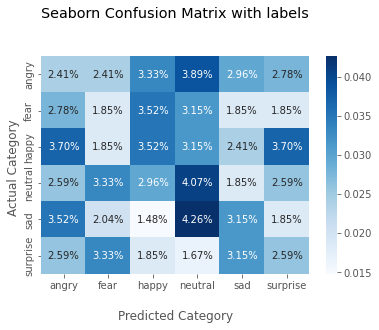

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Schimbare set de date de testare cu cel de validare

Se vor inversa caile in cod pentru cele doua seturi de dateb intre ele. 

Iesirea se va putea vizualiza in outputs/output2, iar cel mai bun model este salvat in checkpoint



---



ANTRENAREA

se va pune in loc de calea /val, /test.

In [10]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output2'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output2/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition2.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 540 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 540 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
25/33 [=====================>........] - ETA: 5s - loss: 2.0735 - accuracy: 0.3416

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 905ms/step - loss: 1.9767 - accuracy: 0.3567 - val_loss: 4.9276 - val_accuracy: 0.1875
Epoch 2/50
20/33 [=================>............] - ETA: 9s - loss: 1.4478 - accuracy: 0.4597 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 1.3968 - accuracy: 0.4743 - val_loss: 3.1309 - val_accuracy: 0.3184
Epoch 3/50
23/33 [===================>..........] - ETA: 7s - loss: 1.2180 - accuracy: 0.5363

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 915ms/step - loss: 1.1980 - accuracy: 0.5427 - val_loss: 1.5160 - val_accuracy: 0.4707
Epoch 4/50
14/33 [===========>..................] - ETA: 14s - loss: 1.0864 - accuracy: 0.5854

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 1.0769 - accuracy: 0.5884 - val_loss: 1.2814 - val_accuracy: 0.5039
Epoch 5/50
31/33 [===========================>..] - ETA: 1s - loss: 0.9323 - accuracy: 0.6406

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 903ms/step - loss: 0.9282 - accuracy: 0.6421 - val_loss: 1.3152 - val_accuracy: 0.5605
Epoch 6/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.8203 - accuracy: 0.6797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 0.8678 - accuracy: 0.6612 - val_loss: 1.1923 - val_accuracy: 0.5664
Epoch 7/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.8606 - accuracy: 0.6504

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.8136 - accuracy: 0.6884 - val_loss: 1.2535 - val_accuracy: 0.5449
Epoch 8/50
 6/33 [====>.........................] - ETA: 19s - loss: 0.7873 - accuracy: 0.7083

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.8045 - accuracy: 0.6904 - val_loss: 1.0142 - val_accuracy: 0.6406
Epoch 9/50
14/33 [===========>..................] - ETA: 13s - loss: 0.7007 - accuracy: 0.7378

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.7084 - accuracy: 0.7334 - val_loss: 0.8551 - val_accuracy: 0.6797
Epoch 10/50
 7/33 [=====>........................] - ETA: 16s - loss: 0.7122 - accuracy: 0.7266

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.6819 - accuracy: 0.7336 - val_loss: 0.9345 - val_accuracy: 0.6543
Epoch 11/50
11/33 [=========>....................] - ETA: 16s - loss: 0.6100 - accuracy: 0.7599

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 897ms/step - loss: 0.6251 - accuracy: 0.7516 - val_loss: 0.7465 - val_accuracy: 0.7090
Epoch 12/50
11/33 [=========>....................] - ETA: 16s - loss: 0.6212 - accuracy: 0.7472

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 801ms/step - loss: 0.6083 - accuracy: 0.7644 - val_loss: 0.8740 - val_accuracy: 0.6855
Epoch 13/50
20/33 [=================>............] - ETA: 9s - loss: 0.5582 - accuracy: 0.7840 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 888ms/step - loss: 0.5654 - accuracy: 0.7810 - val_loss: 0.7878 - val_accuracy: 0.7246
Epoch 14/50
21/33 [==================>...........] - ETA: 9s - loss: 0.5323 - accuracy: 0.7946

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 904ms/step - loss: 0.5392 - accuracy: 0.7950 - val_loss: 0.7085 - val_accuracy: 0.7480
Epoch 15/50
13/33 [==========>...................] - ETA: 15s - loss: 0.5243 - accuracy: 0.7975

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.5247 - accuracy: 0.7970 - val_loss: 0.6853 - val_accuracy: 0.7598
Epoch 16/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.4942 - accuracy: 0.8138

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.5080 - accuracy: 0.8045 - val_loss: 0.6495 - val_accuracy: 0.7793
Epoch 17/50
22/33 [===================>..........] - ETA: 8s - loss: 0.4738 - accuracy: 0.8271

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.4967 - accuracy: 0.8157 - val_loss: 0.7278 - val_accuracy: 0.7324
Epoch 18/50
30/33 [==========================>...] - ETA: 2s - loss: 0.4904 - accuracy: 0.8115

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.4833 - accuracy: 0.8152 - val_loss: 0.6793 - val_accuracy: 0.7754
Epoch 19/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.4356 - accuracy: 0.8464

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.4350 - accuracy: 0.8414 - val_loss: 0.8032 - val_accuracy: 0.7383
Epoch 20/50
 1/33 [..............................] - ETA: 26s - loss: 0.4378 - accuracy: 0.8516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 900ms/step - loss: 0.4435 - accuracy: 0.8286 - val_loss: 0.6277 - val_accuracy: 0.7812
Epoch 21/50
10/33 [========>.....................] - ETA: 17s - loss: 0.3942 - accuracy: 0.8617

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 801ms/step - loss: 0.4004 - accuracy: 0.8480 - val_loss: 0.8564 - val_accuracy: 0.7402
Epoch 22/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.3694 - accuracy: 0.8605

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 895ms/step - loss: 0.3872 - accuracy: 0.8543 - val_loss: 0.8066 - val_accuracy: 0.7910
Epoch 23/50
16/33 [=============>................] - ETA: 13s - loss: 0.3655 - accuracy: 0.8643

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.3760 - accuracy: 0.8570 - val_loss: 0.6651 - val_accuracy: 0.7930
Epoch 24/50
10/33 [========>.....................] - ETA: 15s - loss: 0.3891 - accuracy: 0.8484

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.3846 - accuracy: 0.8485 - val_loss: 0.6832 - val_accuracy: 0.8008
Epoch 25/50
20/33 [=================>............] - ETA: 9s - loss: 0.3536 - accuracy: 0.8676 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.3646 - accuracy: 0.8623 - val_loss: 0.6116 - val_accuracy: 0.7871
Epoch 26/50
25/33 [=====================>........] - ETA: 5s - loss: 0.3550 - accuracy: 0.8662

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 911ms/step - loss: 0.3556 - accuracy: 0.8657 - val_loss: 0.6880 - val_accuracy: 0.8145
Epoch 27/50
29/33 [=========================>....] - ETA: 3s - loss: 0.3199 - accuracy: 0.8782

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.3203 - accuracy: 0.8788 - val_loss: 0.6263 - val_accuracy: 0.8145
Epoch 28/50
25/33 [=====================>........] - ETA: 5s - loss: 0.3323 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.3240 - accuracy: 0.8762 - val_loss: 0.8193 - val_accuracy: 0.7637
Epoch 29/50
 7/33 [=====>........................] - ETA: 21s - loss: 0.3366 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3248 - accuracy: 0.8754 - val_loss: 2.3454 - val_accuracy: 0.7168
Epoch 30/50
16/33 [=============>................] - ETA: 12s - loss: 0.2949 - accuracy: 0.8867

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 904ms/step - loss: 0.3127 - accuracy: 0.8805 - val_loss: 0.5596 - val_accuracy: 0.8340
Epoch 31/50
 4/33 [==>...........................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9258

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.3119 - accuracy: 0.8849 - val_loss: 1.1043 - val_accuracy: 0.7852
Epoch 32/50
16/33 [=============>................] - ETA: 11s - loss: 0.2841 - accuracy: 0.8903

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.3036 - accuracy: 0.8815 - val_loss: 0.6360 - val_accuracy: 0.8008
Epoch 33/50
33/33 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.8953

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.2763 - accuracy: 0.8953 - val_loss: 0.7756 - val_accuracy: 0.7812
Epoch 34/50
25/33 [=====================>........] - ETA: 5s - loss: 0.2630 - accuracy: 0.9008

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2700 - accuracy: 0.8975 - val_loss: 0.5877 - val_accuracy: 0.8320
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2673 - accuracy: 0.8995 - val_loss: 0.7183 - val_accuracy: 0.8027
Epoch 36/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2414 - accuracy: 0.9039

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2412 - accuracy: 0.9070 - val_loss: 0.7108 - val_accuracy: 0.7988
Epoch 37/50
 3/33 [=>............................] - ETA: 21s - loss: 0.2404 - accuracy: 0.9062

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2472 - accuracy: 0.9106 - val_loss: 0.6116 - val_accuracy: 0.8262
Epoch 38/50
12/33 [=========>....................] - ETA: 15s - loss: 0.1974 - accuracy: 0.9277

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 814ms/step - loss: 0.2789 - accuracy: 0.8898 - val_loss: 1.1791 - val_accuracy: 0.7109
Epoch 39/50
30/33 [==========================>...] - ETA: 2s - loss: 0.2870 - accuracy: 0.8915

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.2878 - accuracy: 0.8917 - val_loss: 0.8695 - val_accuracy: 0.7910
Epoch 40/50
15/33 [============>.................] - ETA: 13s - loss: 0.2622 - accuracy: 0.9021

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2620 - accuracy: 0.8944 - val_loss: 0.7095 - val_accuracy: 0.8125
Epoch 41/50
21/33 [==================>...........] - ETA: 8s - loss: 0.2294 - accuracy: 0.9129

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.2305 - accuracy: 0.9089 - val_loss: 0.7641 - val_accuracy: 0.7715
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.1970 - accuracy: 0.9288 - val_loss: 0.7078 - val_accuracy: 0.8145
Epoch 43/50
18/33 [===============>..............] - ETA: 10s - loss: 0.1729 - accuracy: 0.9377

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.1836 - accuracy: 0.9337 - val_loss: 0.7354 - val_accuracy: 0.8145
Epoch 44/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.1769 - accuracy: 0.9385

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.1825 - accuracy: 0.9328 - val_loss: 0.6707 - val_accuracy: 0.8281
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 890ms/step - loss: 0.1730 - accuracy: 0.9349 - val_loss: 0.6312 - val_accuracy: 0.8398
Epoch 46/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.1646 - accuracy: 0.9466

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.1724 - accuracy: 0.9393 - val_loss: 1.8691 - val_accuracy: 0.7793
Epoch 47/50
16/33 [=============>................] - ETA: 12s - loss: 0.2251 - accuracy: 0.9109

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2038 - accuracy: 0.9218 - val_loss: 0.8057 - val_accuracy: 0.8105
Epoch 48/50
22/33 [===================>..........] - ETA: 8s - loss: 0.1636 - accuracy: 0.9403

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.1646 - accuracy: 0.9407 - val_loss: 0.6190 - val_accuracy: 0.8242
Epoch 49/50
29/33 [=========================>....] - ETA: 2s - loss: 0.1715 - accuracy: 0.9321

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.1780 - accuracy: 0.9301 - val_loss: 1.5573 - val_accuracy: 0.7500
Epoch 50/50
29/33 [=========================>....] - ETA: 2s - loss: 0.1846 - accuracy: 0.9334

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.1850 - accuracy: 0.9335 - val_loss: 0.7851 - val_accuracy: 0.8066




---



TESTARE

Se va inlocui calea /test, cu /val.

In [11]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output2/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 529 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 529 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output2/checkpoint...
4/4 [==============================] - 2s 445ms/step - loss: 0.6506 - accuracy: 0.8047
              precision    recall  f1-score   support

           0       0.22      0.21      0.21        95
           1       0.16      0.11      0.13        79
           2       0.23      0.22      0.23        98
           3       0.17      0.20      0.18        92
           4       0.15      0.16      0.16        85
           5       0.17      0.19      0.18        80

    accuracy                           0.19       529
   macro avg       0.18      0.18      0.18       529
weighted avg       0.19      0.19      0.18       529

[INFO] accuracy: 80.47


Matricea de confuzie

In [12]:
%matplotlib inline
plt.close('all')

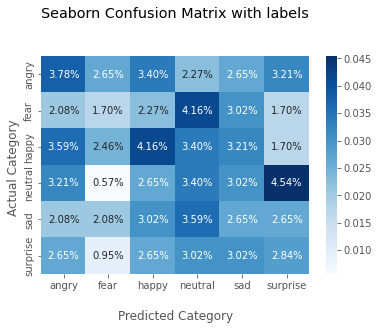

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()




---



# Schimbare ELU cu ReLU in EmotionVGG

SCHIMBARE IN EMOTIONVGG

In [15]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model



---



ANTRENARE

In [16]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output3'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output3/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition3.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition3.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
24/33 [====================>.........] - ETA: 6s - loss: 2.0323 - accuracy: 0.3327

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 916ms/step - loss: 1.9387 - accuracy: 0.3507 - val_loss: 3.9303 - val_accuracy: 0.1816
Epoch 2/50
 5/33 [===>..........................] - ETA: 21s - loss: 1.5011 - accuracy: 0.4422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 900ms/step - loss: 1.4542 - accuracy: 0.4565 - val_loss: 2.0714 - val_accuracy: 0.2383
Epoch 3/50
 1/33 [..............................] - ETA: 27s - loss: 1.2601 - accuracy: 0.5391

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 1.2283 - accuracy: 0.5396 - val_loss: 1.6320 - val_accuracy: 0.2832
Epoch 4/50
22/33 [===================>..........] - ETA: 8s - loss: 1.1097 - accuracy: 0.5871

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 916ms/step - loss: 1.1163 - accuracy: 0.5821 - val_loss: 1.6723 - val_accuracy: 0.3457
Epoch 5/50
18/33 [===============>..............] - ETA: 10s - loss: 1.0123 - accuracy: 0.6228

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 1.0150 - accuracy: 0.6207 - val_loss: 1.6940 - val_accuracy: 0.3164
Epoch 6/50
26/33 [======================>.......] - ETA: 5s - loss: 0.8941 - accuracy: 0.6713

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 880ms/step - loss: 0.9024 - accuracy: 0.6625 - val_loss: 1.4934 - val_accuracy: 0.4277
Epoch 7/50
18/33 [===============>..............] - ETA: 11s - loss: 0.8642 - accuracy: 0.6665

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 965ms/step - loss: 0.8289 - accuracy: 0.6802 - val_loss: 1.2460 - val_accuracy: 0.5117
Epoch 8/50
22/33 [===================>..........] - ETA: 8s - loss: 0.7327 - accuracy: 0.7234

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.7336 - accuracy: 0.7210 - val_loss: 1.3695 - val_accuracy: 0.4785
Epoch 9/50
29/33 [=========================>....] - ETA: 3s - loss: 0.7268 - accuracy: 0.7166

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 931ms/step - loss: 0.7262 - accuracy: 0.7190 - val_loss: 1.0503 - val_accuracy: 0.5898
Epoch 10/50
17/33 [==============>...............] - ETA: 11s - loss: 0.6795 - accuracy: 0.7298

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.6699 - accuracy: 0.7398 - val_loss: 1.1382 - val_accuracy: 0.5742
Epoch 11/50
14/33 [===========>..................] - ETA: 13s - loss: 0.6198 - accuracy: 0.7656

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.6223 - accuracy: 0.7602 - val_loss: 0.8591 - val_accuracy: 0.6758
Epoch 12/50
27/33 [=======================>......] - ETA: 4s - loss: 0.5924 - accuracy: 0.7675

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.5959 - accuracy: 0.7671 - val_loss: 0.7926 - val_accuracy: 0.6641
Epoch 13/50
17/33 [==============>...............] - ETA: 12s - loss: 0.5514 - accuracy: 0.7918

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 1s/step - loss: 0.5682 - accuracy: 0.7856 - val_loss: 0.7173 - val_accuracy: 0.7246
Epoch 14/50
12/33 [=========>....................] - ETA: 14s - loss: 0.5462 - accuracy: 0.7958

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 898ms/step - loss: 0.5547 - accuracy: 0.7868 - val_loss: 0.6945 - val_accuracy: 0.7285
Epoch 15/50
26/33 [======================>.......] - ETA: 5s - loss: 0.4676 - accuracy: 0.8197

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 895ms/step - loss: 0.4744 - accuracy: 0.8167 - val_loss: 0.6269 - val_accuracy: 0.7578
Epoch 16/50
31/33 [===========================>..] - ETA: 1s - loss: 0.4622 - accuracy: 0.8234

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.4761 - accuracy: 0.8179 - val_loss: 0.6767 - val_accuracy: 0.7363
Epoch 17/50
21/33 [==================>...........] - ETA: 8s - loss: 0.4587 - accuracy: 0.8296

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 888ms/step - loss: 0.4665 - accuracy: 0.8254 - val_loss: 0.6354 - val_accuracy: 0.7734
Epoch 18/50
26/33 [======================>.......] - ETA: 5s - loss: 0.4603 - accuracy: 0.8181

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 821ms/step - loss: 0.4655 - accuracy: 0.8191 - val_loss: 0.8188 - val_accuracy: 0.7266
Epoch 19/50
32/33 [============================>.] - ETA: 0s - loss: 0.4449 - accuracy: 0.8301

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.4487 - accuracy: 0.8295 - val_loss: 0.5964 - val_accuracy: 0.7969
Epoch 20/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.3659 - accuracy: 0.8717

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.4113 - accuracy: 0.8443 - val_loss: 0.6459 - val_accuracy: 0.7754
Epoch 21/50
31/33 [===========================>..] - ETA: 1s - loss: 0.4149 - accuracy: 0.8402

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 812ms/step - loss: 0.4087 - accuracy: 0.8431 - val_loss: 0.5899 - val_accuracy: 0.7910
Epoch 22/50
22/33 [===================>..........] - ETA: 7s - loss: 0.3545 - accuracy: 0.8672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 898ms/step - loss: 0.3606 - accuracy: 0.8633 - val_loss: 0.5607 - val_accuracy: 0.8008
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.3513 - accuracy: 0.8667 - val_loss: 0.6537 - val_accuracy: 0.7793
Epoch 24/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3626 - accuracy: 0.8675

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3675 - accuracy: 0.8647 - val_loss: 0.6206 - val_accuracy: 0.7910
Epoch 25/50
24/33 [====================>.........] - ETA: 6s - loss: 0.3368 - accuracy: 0.8732

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.3323 - accuracy: 0.8735 - val_loss: 0.6370 - val_accuracy: 0.7793
Epoch 26/50
12/33 [=========>....................] - ETA: 15s - loss: 0.3183 - accuracy: 0.8853

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 835ms/step - loss: 0.3368 - accuracy: 0.8754 - val_loss: 0.5740 - val_accuracy: 0.7930
Epoch 27/50
11/33 [=========>....................] - ETA: 15s - loss: 0.2779 - accuracy: 0.8986

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.3192 - accuracy: 0.8783 - val_loss: 0.7179 - val_accuracy: 0.7578
Epoch 28/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.3070 - accuracy: 0.8898

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 963ms/step - loss: 0.3021 - accuracy: 0.8890 - val_loss: 0.5969 - val_accuracy: 0.8066
Epoch 29/50
20/33 [=================>............] - ETA: 10s - loss: 0.2963 - accuracy: 0.8879

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 851ms/step - loss: 0.3006 - accuracy: 0.8856 - val_loss: 0.8324 - val_accuracy: 0.7539
Epoch 30/50
25/33 [=====================>........] - ETA: 6s - loss: 0.2877 - accuracy: 0.8988

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.2799 - accuracy: 0.9004 - val_loss: 0.5936 - val_accuracy: 0.8066
Epoch 31/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2562 - accuracy: 0.9066

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 0.2661 - accuracy: 0.9021 - val_loss: 0.5990 - val_accuracy: 0.8125
Epoch 32/50
21/33 [==================>...........] - ETA: 8s - loss: 0.2740 - accuracy: 0.8970

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.2701 - accuracy: 0.9000 - val_loss: 0.6759 - val_accuracy: 0.8047
Epoch 33/50
12/33 [=========>....................] - ETA: 15s - loss: 0.2362 - accuracy: 0.9147

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2515 - accuracy: 0.9087 - val_loss: 0.8676 - val_accuracy: 0.7637
Epoch 34/50
15/33 [============>.................] - ETA: 13s - loss: 0.2648 - accuracy: 0.9031

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2666 - accuracy: 0.9019 - val_loss: 0.6220 - val_accuracy: 0.7871
Epoch 35/50
28/33 [========================>.....] - ETA: 3s - loss: 0.2543 - accuracy: 0.9060

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2594 - accuracy: 0.9036 - val_loss: 0.7781 - val_accuracy: 0.7852
Epoch 36/50
14/33 [===========>..................] - ETA: 13s - loss: 0.2339 - accuracy: 0.9193

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.2485 - accuracy: 0.9065 - val_loss: 0.6686 - val_accuracy: 0.7891
Epoch 37/50
24/33 [====================>.........] - ETA: 6s - loss: 0.2284 - accuracy: 0.9150

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.2220 - accuracy: 0.9184 - val_loss: 0.6379 - val_accuracy: 0.8008
Epoch 38/50
24/33 [====================>.........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9167

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.2270 - accuracy: 0.9177 - val_loss: 1.4446 - val_accuracy: 0.6426
Epoch 39/50
 2/33 [>.............................] - ETA: 21s - loss: 0.2719 - accuracy: 0.9102

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2230 - accuracy: 0.9165 - val_loss: 0.9284 - val_accuracy: 0.7617
Epoch 40/50
 3/33 [=>............................] - ETA: 22s - loss: 0.1986 - accuracy: 0.9193

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.2084 - accuracy: 0.9179 - val_loss: 0.6996 - val_accuracy: 0.8203
Epoch 41/50
 3/33 [=>............................] - ETA: 21s - loss: 0.1704 - accuracy: 0.9453

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2014 - accuracy: 0.9262 - val_loss: 0.6402 - val_accuracy: 0.8145
Epoch 42/50
15/33 [============>.................] - ETA: 13s - loss: 0.2047 - accuracy: 0.9240

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 786ms/step - loss: 0.2048 - accuracy: 0.9240 - val_loss: 0.6128 - val_accuracy: 0.8047
Epoch 43/50
22/33 [===================>..........] - ETA: 8s - loss: 0.1972 - accuracy: 0.9339

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.1928 - accuracy: 0.9332 - val_loss: 0.6395 - val_accuracy: 0.8145
Epoch 44/50
20/33 [=================>............] - ETA: 9s - loss: 0.1724 - accuracy: 0.9348 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.1873 - accuracy: 0.9303 - val_loss: 2.4731 - val_accuracy: 0.7305
Epoch 45/50
32/33 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.9040

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2564 - accuracy: 0.9043 - val_loss: 0.9157 - val_accuracy: 0.7480
Epoch 46/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2277 - accuracy: 0.9219

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.2186 - accuracy: 0.9228 - val_loss: 0.7131 - val_accuracy: 0.7891
Epoch 47/50
 7/33 [=====>........................] - ETA: 18s - loss: 0.2033 - accuracy: 0.9275

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.2064 - accuracy: 0.9235 - val_loss: 0.8864 - val_accuracy: 0.7676
Epoch 48/50
 3/33 [=>............................] - ETA: 23s - loss: 0.2142 - accuracy: 0.9193

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.1844 - accuracy: 0.9274 - val_loss: 0.6662 - val_accuracy: 0.7734
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.1924 - accuracy: 0.9281 - val_loss: 0.7288 - val_accuracy: 0.7891
Epoch 50/50
 5/33 [===>..........................] - ETA: 16s - loss: 0.1765 - accuracy: 0.9307

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 0.1550 - accuracy: 0.9412 - val_loss: 0.6088 - val_accuracy: 0.8320




---



TESTARE

In [17]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output3/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output3/checkpoint...
4/4 [==============================] - 2s 459ms/step - loss: 0.6139 - accuracy: 0.8301
              precision    recall  f1-score   support

           0       0.17      0.16      0.16        96
           1       0.12      0.14      0.13        81
           2       0.16      0.16      0.16        99
           3       0.17      0.16      0.16        94
           4       0.15      0.15      0.15        88
           5       0.14      0.13      0.14        82

    accuracy                           0.15       540
   macro avg       0.15      0.15      0.15       540
weighted avg       0.15      0.15      0.15       540

[INFO] accuracy: 83.01


Matrice de confuzie

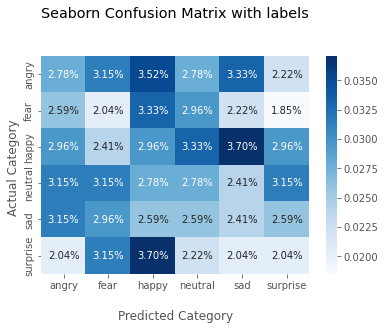

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---



# Adaugarea unui nou bloc in EmotionVGG

SCHIMBARE IN EMOTIONVGG

In [19]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ELU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        #BLOC 5 - NOU ADAUGAT
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ELU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model



---



ANTRENARE

In [20]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output4'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output4/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition4.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition4.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
15/33 [============>.................] - ETA: 12s - loss: 2.3678 - accuracy: 0.3010

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 937ms/step - loss: 2.1851 - accuracy: 0.3232 - val_loss: 11.5489 - val_accuracy: 0.1445
Epoch 2/50
21/33 [==================>...........] - ETA: 8s - loss: 1.7958 - accuracy: 0.3706

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 921ms/step - loss: 1.7529 - accuracy: 0.3902 - val_loss: 2.5017 - val_accuracy: 0.2793
Epoch 3/50
14/33 [===========>..................] - ETA: 14s - loss: 1.5776 - accuracy: 0.4319

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.5422 - accuracy: 0.4451 - val_loss: 1.6486 - val_accuracy: 0.3809
Epoch 4/50
22/33 [===================>..........] - ETA: 8s - loss: 1.3956 - accuracy: 0.4768

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 920ms/step - loss: 1.3752 - accuracy: 0.4886 - val_loss: 1.4628 - val_accuracy: 0.4375
Epoch 5/50
14/33 [===========>..................] - ETA: 12s - loss: 1.2241 - accuracy: 0.5451

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 1.2389 - accuracy: 0.5321 - val_loss: 1.6283 - val_accuracy: 0.4375
Epoch 6/50
14/33 [===========>..................] - ETA: 14s - loss: 1.1812 - accuracy: 0.5402

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.1307 - accuracy: 0.5576 - val_loss: 1.0290 - val_accuracy: 0.5957
Epoch 7/50
27/33 [=======================>......] - ETA: 4s - loss: 1.0784 - accuracy: 0.5854

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 1.0697 - accuracy: 0.5881 - val_loss: 0.9806 - val_accuracy: 0.5957
Epoch 8/50
18/33 [===============>..............] - ETA: 10s - loss: 0.9824 - accuracy: 0.6087

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 0.9605 - accuracy: 0.6226 - val_loss: 0.9421 - val_accuracy: 0.6309
Epoch 9/50
19/33 [================>.............] - ETA: 10s - loss: 0.9330 - accuracy: 0.6341

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.9168 - accuracy: 0.6442 - val_loss: 0.8026 - val_accuracy: 0.7031
Epoch 10/50
22/33 [===================>..........] - ETA: 8s - loss: 0.8764 - accuracy: 0.6672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.8612 - accuracy: 0.6714 - val_loss: 0.7032 - val_accuracy: 0.7168
Epoch 11/50
11/33 [=========>....................] - ETA: 15s - loss: 0.8296 - accuracy: 0.6797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.8381 - accuracy: 0.6785 - val_loss: 0.7863 - val_accuracy: 0.6875
Epoch 12/50
18/33 [===============>..............] - ETA: 10s - loss: 0.7707 - accuracy: 0.7034

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 924ms/step - loss: 0.7783 - accuracy: 0.7045 - val_loss: 0.6767 - val_accuracy: 0.7441
Epoch 13/50
21/33 [==================>...........] - ETA: 9s - loss: 0.7557 - accuracy: 0.6998

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.7550 - accuracy: 0.7035 - val_loss: 0.6591 - val_accuracy: 0.7402
Epoch 14/50
 1/33 [..............................] - ETA: 26s - loss: 0.7126 - accuracy: 0.7188

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 791ms/step - loss: 0.7391 - accuracy: 0.7142 - val_loss: 0.8124 - val_accuracy: 0.6836
Epoch 15/50
 3/33 [=>............................] - ETA: 22s - loss: 0.7259 - accuracy: 0.7240

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.7111 - accuracy: 0.7341 - val_loss: 0.7295 - val_accuracy: 0.7344
Epoch 16/50
19/33 [================>.............] - ETA: 10s - loss: 0.6545 - accuracy: 0.7516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.6521 - accuracy: 0.7530 - val_loss: 0.6566 - val_accuracy: 0.7500
Epoch 17/50
26/33 [======================>.......] - ETA: 5s - loss: 0.6483 - accuracy: 0.7480

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 821ms/step - loss: 0.6437 - accuracy: 0.7516 - val_loss: 0.6761 - val_accuracy: 0.7402
Epoch 18/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5922 - accuracy: 0.7665

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 902ms/step - loss: 0.5899 - accuracy: 0.7674 - val_loss: 0.6450 - val_accuracy: 0.7578
Epoch 19/50
 6/33 [====>.........................] - ETA: 19s - loss: 0.5698 - accuracy: 0.7674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.5715 - accuracy: 0.7734 - val_loss: 0.8007 - val_accuracy: 0.6934
Epoch 20/50
24/33 [====================>.........] - ETA: 6s - loss: 0.5578 - accuracy: 0.7930

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.5605 - accuracy: 0.7931 - val_loss: 0.6955 - val_accuracy: 0.7363
Epoch 21/50
31/33 [===========================>..] - ETA: 1s - loss: 0.5361 - accuracy: 0.7911

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.5353 - accuracy: 0.7909 - val_loss: 0.7387 - val_accuracy: 0.7266
Epoch 22/50
28/33 [========================>.....] - ETA: 3s - loss: 0.5442 - accuracy: 0.7967

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.5395 - accuracy: 0.7980 - val_loss: 0.7335 - val_accuracy: 0.7363
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.5050 - accuracy: 0.8072 - val_loss: 0.7657 - val_accuracy: 0.7441
Epoch 24/50
 9/33 [=======>......................] - ETA: 16s - loss: 0.5049 - accuracy: 0.8011

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.4985 - accuracy: 0.8067 - val_loss: 0.7545 - val_accuracy: 0.7168
Epoch 25/50
 5/33 [===>..........................] - ETA: 19s - loss: 0.5191 - accuracy: 0.8000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.4910 - accuracy: 0.8137 - val_loss: 0.6380 - val_accuracy: 0.7676
Epoch 26/50
18/33 [===============>..............] - ETA: 11s - loss: 0.4471 - accuracy: 0.8212

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.4719 - accuracy: 0.8174 - val_loss: 0.6393 - val_accuracy: 0.7695
Epoch 27/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.4791 - accuracy: 0.8092

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.4469 - accuracy: 0.8273 - val_loss: 0.5756 - val_accuracy: 0.7891
Epoch 28/50
28/33 [========================>.....] - ETA: 3s - loss: 0.4117 - accuracy: 0.8440

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.4051 - accuracy: 0.8468 - val_loss: 0.6149 - val_accuracy: 0.7793
Epoch 29/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.4207 - accuracy: 0.8312

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 816ms/step - loss: 0.4124 - accuracy: 0.8407 - val_loss: 0.7375 - val_accuracy: 0.7520
Epoch 30/50
 5/33 [===>..........................] - ETA: 20s - loss: 0.3809 - accuracy: 0.8531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.3856 - accuracy: 0.8519 - val_loss: 0.6696 - val_accuracy: 0.7617
Epoch 31/50
 5/33 [===>..........................] - ETA: 20s - loss: 0.3953 - accuracy: 0.8469

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.3825 - accuracy: 0.8541 - val_loss: 0.5306 - val_accuracy: 0.8223
Epoch 32/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.3318 - accuracy: 0.8770

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.3859 - accuracy: 0.8516 - val_loss: 0.6226 - val_accuracy: 0.7969
Epoch 33/50
23/33 [===================>..........] - ETA: 7s - loss: 0.3851 - accuracy: 0.8534

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.3910 - accuracy: 0.8514 - val_loss: 0.6242 - val_accuracy: 0.7930
Epoch 34/50
 3/33 [=>............................] - ETA: 21s - loss: 0.3480 - accuracy: 0.8724

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.3466 - accuracy: 0.8672 - val_loss: 0.6061 - val_accuracy: 0.8008
Epoch 35/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.2932 - accuracy: 0.8929

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.3363 - accuracy: 0.8723 - val_loss: 0.8266 - val_accuracy: 0.7480
Epoch 36/50
32/33 [============================>.] - ETA: 0s - loss: 0.3338 - accuracy: 0.8742

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.3334 - accuracy: 0.8745 - val_loss: 0.6679 - val_accuracy: 0.7871
Epoch 37/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3311 - accuracy: 0.8741

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.3203 - accuracy: 0.8781 - val_loss: 0.6634 - val_accuracy: 0.7871
Epoch 38/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.2707 - accuracy: 0.8984

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.2969 - accuracy: 0.8856 - val_loss: 0.6251 - val_accuracy: 0.7930
Epoch 39/50
31/33 [===========================>..] - ETA: 1s - loss: 0.2702 - accuracy: 0.8988

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.2706 - accuracy: 0.8983 - val_loss: 0.5967 - val_accuracy: 0.8066
Epoch 40/50
 3/33 [=>............................] - ETA: 12s - loss: 0.2493 - accuracy: 0.9029

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.2737 - accuracy: 0.8985 - val_loss: 0.7108 - val_accuracy: 0.7773
Epoch 41/50
15/33 [============>.................] - ETA: 13s - loss: 0.2793 - accuracy: 0.8896

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.2825 - accuracy: 0.8944 - val_loss: 0.6294 - val_accuracy: 0.8105
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2733 - accuracy: 0.8958 - val_loss: 0.6230 - val_accuracy: 0.8047
Epoch 43/50
 1/33 [..............................] - ETA: 24s - loss: 0.2314 - accuracy: 0.9297

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2390 - accuracy: 0.9150 - val_loss: 0.6981 - val_accuracy: 0.7734
Epoch 44/50
10/33 [========>.....................] - ETA: 15s - loss: 0.2111 - accuracy: 0.9242

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.2268 - accuracy: 0.9160 - val_loss: 0.7317 - val_accuracy: 0.7734
Epoch 45/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2167 - accuracy: 0.9195

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.2226 - accuracy: 0.9206 - val_loss: 0.5953 - val_accuracy: 0.8008
Epoch 46/50
 9/33 [=======>......................] - ETA: 16s - loss: 0.2444 - accuracy: 0.9063

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2625 - accuracy: 0.9014 - val_loss: 0.6730 - val_accuracy: 0.8008
Epoch 47/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2709 - accuracy: 0.9070

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.2530 - accuracy: 0.9053 - val_loss: 0.6717 - val_accuracy: 0.7910
Epoch 48/50
21/33 [==================>...........] - ETA: 8s - loss: 0.2361 - accuracy: 0.9070

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.2324 - accuracy: 0.9114 - val_loss: 0.6648 - val_accuracy: 0.8086
Epoch 49/50
 3/33 [=>............................] - ETA: 24s - loss: 0.2204 - accuracy: 0.9219

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2208 - accuracy: 0.9153 - val_loss: 0.7587 - val_accuracy: 0.7871
Epoch 50/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.2069 - accuracy: 0.9297

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.2099 - accuracy: 0.9211 - val_loss: 0.6706 - val_accuracy: 0.7949




---



TESTARE

In [21]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output4/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output4/checkpoint...
4/4 [==============================] - 2s 467ms/step - loss: 0.6089 - accuracy: 0.8066
              precision    recall  f1-score   support

           0       0.18      0.19      0.18        96
           1       0.17      0.14      0.15        81
           2       0.21      0.21      0.21        99
           3       0.14      0.14      0.14        94
           4       0.18      0.17      0.17        88
           5       0.22      0.27      0.24        82

    accuracy                           0.19       540
   macro avg       0.18      0.19      0.18       540
weighted avg       0.18      0.19      0.18       540

[INFO] accuracy: 80.66


Matrice de confuzie

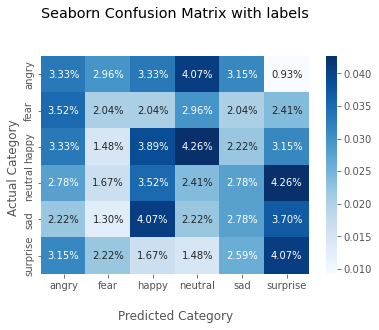

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---

